In [1]:
import argparse
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from write_script import get_ckpt_folder, get_epochs, mk_metrics_folder, mk_metrics_folder, get_experiment_folders_and_epochs
import matplotlib.image as mpimg
from os import listdir
from os.path import isfile, join
import re
from scipy import stats

# Now let's see how the results look like

In [2]:
class arguments:
    "Argument class"
    
    def __init__(self):
        self.dataset = 'IWSLT' # choice ['IWSLT', 'WMT']
        self.training_type = 'normal' # choice ['const_lr', 'normal']
        self.experiment_type = 'width' # choice ['sample', 'lr']
        self.second_exp = False
        self.mkdir = False
        self.IWSLT_width = 128
        self.only20 = False

In [3]:
def get_file(ckpt_folder, epoch):
    
    #ww_result = os.path.join(ckpt_folder, 'metrics', f'epoch_{epoch}', 'results.pkl')
    #ww_result = os.path.join(ckpt_folder, 'metrics', f'epoch_{epoch}', 'results_continuous30.pkl')
    #ww_result = os.path.join(ckpt_folder, 'metrics', f'epoch_{epoch}', 'results_continuous30_heuMax_1.pkl')
    #ww_result = os.path.join(ckpt_folder, 'metrics_new', f'epoch_{epoch}', 'results.pkl')
    #ww_result = os.path.join(ckpt_folder, 'metrics_new', f'epoch_{epoch}', 'results_Charles_fix_finger.pkl')
    #ww_result = os.path.join(ckpt_folder, 'metrics_new', f'epoch_{epoch}', 'results_Charles_rand_distance.pkl')
    #ww_result = os.path.join(ckpt_folder, 'metrics_expcutoff', f'epoch_{epoch}', 'results.pkl')
    #ww_result = os.path.join(ckpt_folder, 'metrics_expcutoff_positive_lambda', f'epoch_{epoch}', 'results.pkl')
    #ww_result = os.path.join(ckpt_folder, 'metrics_lognormal', f'epoch_{epoch}', 'results.pkl')
    ww_result = os.path.join(ckpt_folder, 'metrics_exponential', f'epoch_{epoch}', 'results.pkl')
    loss_result = os.path.join(ckpt_folder, 'log_0.txt')

    return ww_result, loss_result


def get_ESD(ckpt_folder, epoch, ESD_type=1, layer_id=105):
    
    if ESD_type == 1:
        esd_suffix = f'esd'
    elif ESD_type in [2,3,4]:
        esd_suffix = f'esd{ESD_type}'
    elif ESD_type in [5,6]:
        esd_suffix = f'mpfit{ESD_type-4}'
    elif ESD_type in [7,8]:
        esd_suffix = f'randesd.{ESD_type-6}'

    ESD_result = os.path.join(ckpt_folder, 'metrics_expcutoff', f'epoch_{epoch}', f'ww.layer{layer_id}.{esd_suffix}.png')

    return ESD_result


def compute_alpha_from_Ds(alphas, Ds, alpha_threshold=6, softmin=False, all_alpha=False, return_D=False, spectral_norms=None):
    
    temperature = 100
    layers = alphas.keys()
    # remove the last 10 points
    remove_last = 1
    
    alpha_layers = []
    D_layers = []
    for layer in layers:
        
        Ds_this_layer = Ds[layer]#[:-remove_last]
        alphas_this_layer = alphas[layer]#[:-remove_last]
        
        # remove the outliers
        mask = alphas_this_layer<alpha_threshold
        Ds_this_layer = Ds_this_layer[mask]
        alphas_this_layer = alphas_this_layer[mask]
        
        # This is the hardmin way
        #if len(Ds_this_layer)==0:
        #    alpha_layers.append(0)
        #    D_layers.append(0)
        #    continue
            
        min_D_index = np.argmin(Ds_this_layer)
        alpha_layers.append(alphas_this_layer[min_D_index])
        
        #print('-'*10)
        #print('layer', layer)
        #print('min_D_index', min_D_index)
        #print('alpha', alphas_this_layer[min_D_index])
        #print('size of the layer', len(alphas_this_layer))
        #print('D value', min(Ds_this_layer))
        
        # One possible solution is to directly add the 0-th entry
        #alpha_layers.append(alphas_this_layer[0])
        
        # How wide is the KS valley?
        #alpha_layers.append(np.sum(Ds_this_layer<0.15)/len(Ds_this_layer)*3)
        min_D = min(Ds_this_layer)
        D_layers.append(min_D)
        
        # This is the softmin way
        #WeightsD = np.exp(-temperature*Ds_this_layer)/sum(np.exp(-temperature*Ds_this_layer))
        #alpha_layers.append(alphas_this_layer.dot(WeightsD)) 
        
        # What about simple average?
        #alpha_layers.append(np.mean(alphas_this_layer))
        #alpha_layers.append(np.mean(Ds_this_layer*10))
        #alpha_layers.append(np.mean(alphas_this_layer[-10:]))
        
    # Get weighted alpha
    alpha_hat = alpha_layers*np.array(spectral_norms)
    #alpha = np.mean(alpha_hat)
    # Get spectral norm
    #alpha = np.mean(spectral_norms)
    # Get mean of alpha
    alpha = np.mean(alpha_layers)
    # Get min of alpha
    #alpha = np.min(alpha_layers)
    # Get mean of Ds
    #alpha = np.mean(D_layers)
    print('Got alpha from Ds')
    
    if return_D:
        print('Return D values')
        return D_layers
    if not all_alpha:
        #print('Return alpha values')
        #return alpha
        return alpha, {'alpha_hat': alpha_hat, 'alphas':alpha_layers, 'spectral_norms': spectral_norms}
    else:
        return alpha_layers


def get_ww_layer_feature(ww_result, key):

    with open(ww_result, 'rb') as f:
        dict0 = pickle.load(f)
        feature_values = [dict0['details'][key][layer] for layer in dict0['details'][key].keys()]
        
        return feature_values
    
    
def get_alphas_Ds(ww_result):
    
    with open(ww_result, 'rb') as f:
        dict0 = pickle.load(f)
        alphas = dict0['alphas']
        Ds = dict0['Ds']
    
    return alphas, Ds
                
    
def get_ww_alpha_from_Ds(ww_result, all_alpha=False, return_D=False):
    
    alphas, Ds = get_alphas_Ds(ww_result)
    
    spectral_norms = get_ww_layer_feature(ww_result, 'log_spectral_norm')
    
    #print("Raw data for")
    #print(ww_result)
    
    if all_alpha:
        result = compute_alpha_from_Ds(alphas, Ds, all_alpha=all_alpha, return_D=return_D, spectral_norms=spectral_norms)
    else:
        result, raw_results = compute_alpha_from_Ds(alphas, Ds, all_alpha=all_alpha, return_D=return_D, spectral_norms=spectral_norms)
    
    #raw_result_file = ww_result[:-24]+'results_raw_alphas.pkl'
    #if not os.path.exists(raw_result_file):
    #    with open(raw_result_file, 'wb') as f:
    #        pickle.dump(raw_results, f)
    
    return result


def get_ww_result(plot_result, ww_result, keys, get_alpha_from_Ds=False, min_alpha=False):

    #print(ww_result)
    with open(ww_result, 'rb') as f:
        dict0 = pickle.load(f)
        for key in keys:
            if key not in ['rand_num_spikes', 'rand_distance', 'entropy', 'exponent', 'D', 'sigma_var']:
                if get_alpha_from_Ds and key=='alpha':
                    #print('Get alpha from Ds')
                    alpha_value = get_ww_alpha_from_Ds(ww_result)
                    plot_result[key].append(alpha_value)
                elif key=='alpha' and min_alpha:
                    plot_result[key].append(dict0['details'][key].min())
                elif key=='num_spikes':
                    plot_result[key].append(dict0['details'][key].sum()/1000)
                else:
                    plot_result[key].append(dict0['summary'][key])
            else:
                layer_values = [dict0['details'][key][epoch] for epoch in dict0['details'][key].keys()]
                #if key == 'sigma_var':
                #    print(layer_values)
                if None in layer_values:
                    plot_result[key].append(0)
                    print("None encountered in calculation!")
                else:
                    plot_result[key].append(np.mean(layer_values))

            
def get_ww_alpha(ww_result):

    with open(ww_result, 'rb') as f:
        dict0 = pickle.load(f)
        alpha_value = dict0['summary']['alpha']
        
    return alpha_value


def get_ww_layer_alpha(ww_result, from_Ds=False):

    with open(ww_result, 'rb') as f:
        dict0 = pickle.load(f)
        if not from_Ds:
            alpha_values = [dict0['details']['alpha'][key] for key in dict0['details']['alpha'].keys()]
        else:
            alpha_values = get_ww_alpha_from_Ds(ww_result, all_alpha=True)
        
        return alpha_values

    
def get_ww_layer_metrics(ww_result, per_layer):
    
    if per_layer=='spikes':
        per_layer_feature = 'rand_num_spikes'
    else:
        per_layer_feature = per_layer
        
    with open(ww_result, 'rb') as f:
        dict0 = pickle.load(f)
        spike_values = [dict0['details'][per_layer_feature][key] for key in dict0['details'][per_layer_feature].keys()]
        
        return spike_values


def get_val_loss(plot_result, loss_result):

    plot_result['validation_loss'] = [] 
    with open(loss_result, 'r') as file:
        lines = file.readlines()
        for x in lines:
            x = x.split(' ')
            if 'validation' and 'loss' in x:
                plot_result['validation_loss'].append(float(x[-1]))

                
def get_bleu_score(plot_result, loss_result, divide):

    plot_result['bleu_score'] = [] 
    with open(loss_result, 'r') as file:
        lines = file.readlines()
        for x in lines:
            x = x.split(' ')
            if 'BLEU' in x and 'at' in x and 'score' in x:
                plot_result['bleu_score'].append(float(x[-1])*100/divide)
                
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


def get_train_loss(plot_result, loss_result):

    plot_result['training_loss'] = [] 
    with open(loss_result, 'r') as file:
        lines = file.readlines()
        for x in lines:
            x = x.split(' ')
            if 'training' and 'loss=' in x:
                plot_result['training_loss'].append(float(x[-1]))
        plot_result['training_loss'] = smooth(plot_result['training_loss'], box_pts=20)


def get_per_layer_curves_one_epoch(plot_result, ww_result, keys, layer_ids, from_Ds=False):
    
    with open(ww_result, 'rb') as f:
        dict0 = pickle.load(f)
    
    if from_Ds:
        
        Ds = get_ww_alpha_from_Ds(ww_result, return_D=True)
        for layer_index, layer in enumerate(layer_ids):
            value = Ds[layer_index]
            plot_result['D'][layer].append(value)
        return
    
    for key in keys:
        for layer_index, layer in enumerate(layer_ids):
            value = dict0['details'][key][layer_index]
            plot_result[key][layer].append(value)
            

In [4]:
def plot_all_layers(ckpt_folder, epochs, layer_ids = [21, 22], ESD_type = 1, save=None, from_Ds=False, plot_difference=False):
    
    #print(len(epochs))
    #print(len(layer_ids))
    
    fig, axs = plt.subplots(len(epochs), len(layer_ids), figsize=(2.5*len(layer_ids), 2.5*len(epochs)))
    
    for row, epoch in enumerate(epochs):
        print("Starting epoch {0}".format(epoch))
        
        if from_Ds:
            
            ww_result, _ = get_file(ckpt_folder, epoch)
            alphas, Ds = get_alphas_Ds(ww_result)
            if epoch>0:
                ww_result_previous, _ = get_file(ckpt_folder, epoch-1)
                alphas_previous, Ds_previous = get_alphas_Ds(ww_result_previous)
            
        for col, layer_id in enumerate(layer_ids):

            ax = axs[row, col]
            
            if not from_Ds:
                ESD_result = get_ESD(ckpt_folder, epoch, ESD_type=ESD_type, layer_id=layer_id)
                img = mpimg.imread(ESD_result)
                ax.imshow(img)
                ax.axis('off')
            else:
                alphas_layer = alphas[layer_id]
                if epoch >0 and plot_difference:
                    alphas_layer = alphas[layer_id] - alphas_previous[layer_id]
                    
                if epoch>0 and layer_id==291:
                    print(f"Epoch = {epoch}")
                    print(f"Alpha maximum value is {max(alphas[layer_id])}")
                
                if not plot_difference or epoch==0:
                    ax.plot(alphas_layer)
                else:
                    ax.plot(alphas_layer, 'r')
                    ax.plot(-alphas_layer, 'b')
                ax.set_title(f'Alphas for layer {layer_id}')
                ax.set_ylim([0,7])
                ax.grid()
                
    plt.tight_layout()
    if save:
        plt.savefig(save, dpi=300)
        plt.clf()
    else:
        plt.show()
        

In [5]:
def plot_once(args, ckpt_folders, epoch_collections, draw_per_epoch=False, 
              ESD=False, layer_id = 105, ESD_type = 1, save=None, per_layer='alpha',
             get_alpha_from_Ds=False, from_Ds=False, plot_layer_curves=False, layer_ids=[], 
              special_legend=None, additional_keys=[], min_alpha=False, divide=10, ymax=0):
    
    if not draw_per_epoch:
        fig, axs = plt.subplots(1, len(ckpt_folders), figsize=(5*len(ckpt_folders),5))
    else:
        lengths = [len(epoch_collections[i]) for i in range(len(epoch_collections))]
        fig, axs = plt.subplots(max(lengths), len(ckpt_folders), figsize=(2.5*len(ckpt_folders), 2.5*len(epoch_collections[0])))
            
    constant_lr = args.training_type == 'const_lr'
    if args.second_exp:
        width_list = [64, 128, 256, 512]
    else:
        width_list = [128, 256, 512, 768, 1024, 1536]
    if args.dataset == 'IWSLT':
        sample_list = [10000, 20000, 40000, 80000, 160000]
    elif args.dataset == 'WMT':
        sample_list = [160000, 320000, 640000, 1280000]
    lr_factor_list = ['0.25', '0.5', '1', '2', '4']

    if args.experiment_type == 'width':
        val_list = width_list
        val_type = 'Embedding width'
    elif args.experiment_type == 'sample':
        val_list = sample_list
        val_type = 'Num samples'
    elif args.experiment_type == 'lr':
        val_list = lr_factor_list
        val_type = 'Lr'
    elif args.experiment_type == 'CV':
        val_list = [18]
        val_type = 'ResNet'

    keys = ['log_norm', 'alpha', 'alpha_weighted', 'log_alpha_norm', 'log_spectral_norm', 'stable_rank', 'D']
    if per_layer=='spikes':
        keys += ['rand_num_spikes']
    if len(additional_keys)>0:
        for key in additional_keys:
            if key not in keys:
                keys.append(key)
    if plot_layer_curves:
        keys += ['D']

    # these are the validation loss at the beginning of training. Some checkpoints to not have these values
    val_losses_at_beginning = {64:7.588486796931217, 128:7.591086287247507, 256:7.581291248923854, 512:7.59, 768: 7.79, 1024:7.59, 1536: 7.59}

    for col, val in enumerate(val_list):
        
        ax = axs[col]
        
        plot_result = {key:[] for key in keys}
        ckpt_folder = ckpt_folders[col]
        epochs = epoch_collections[col]
        
        missing_results = False
        # get plots for different epochs
        
        if plot_layer_curves:
            plot_result = {key:{layer:[] for layer in layer_ids} for key in keys}                
        
        for row, epoch in enumerate(epochs):
            
            ww_result, loss_result = get_file(ckpt_folder, epoch)
            
            if plot_layer_curves:
                get_per_layer_curves_one_epoch(plot_result, ww_result, keys, layer_ids, from_Ds=from_Ds)
                continue
                
            if (not os.path.exists(ww_result)) or (not os.path.exists(loss_result)):
                print(f'Missing result {ww_result} or {loss_result}')
                missing_results = True
                break
            get_ww_result(plot_result, ww_result, keys, get_alpha_from_Ds=get_alpha_from_Ds, min_alpha=min_alpha)
            if not draw_per_epoch:
                get_bleu_score(plot_result, loss_result, divide=divide)
                get_val_loss(plot_result, loss_result)
                get_train_loss(plot_result, loss_result)
            
            # new_things
            
            if draw_per_epoch:
                ax = axs[row, col]
                if not ESD:
                    if per_layer=='alpha':
                        alpha_values = get_ww_layer_alpha(ww_result, from_Ds=from_Ds)
                    else:
                        alpha_values = get_ww_layer_metrics(ww_result, per_layer)
                        print(alpha_values)
                    alpha_value = get_ww_alpha(ww_result)
                    ax.scatter(np.arange(len(alpha_values)), alpha_values, c='r')

                    ax.set_title(f'Epoch-{epoch}, {val_type}={val}\nalpha={alpha_value}', fontsize=10)
                    if per_layer=='alpha':
                        ax.set_ylabel('Per-module alpha', fontsize=10)
                    else:
                        ax.set_ylabel(f'Per-module {per_layer}', fontsize=10)
                    ax.set_xlabel('Module index', fontsize=10)
                    ax.set_ylim([0, 3])
                else:
                    ESD_result = get_ESD(ckpt_folder, epoch, ESD_type=ESD_type, layer_id=layer_id)
                    img = mpimg.imread(ESD_result)
                    ax.imshow(img)
                    ax.axis('off')
        
        if missing_results:
            
            print(f"Missing results for val={val}. Continue to next value")
            continue
            
        # get the plots for the whole training
        if not draw_per_epoch:
            
            #print("Pointing to this part")
            
            if args.experiment_type == 'width':
                epochs = [x+1 for x in epochs]
            
            if plot_layer_curves:
                
                for key in ['D']:
                    for layer in layer_ids:
                        ax.plot(epochs, plot_result[key][layer])
            
            elif len(additional_keys)==0:
                
                for key in ['alpha']:
                #for key in ['log_spectral_norm']:
                    #print('smoothing alpha')
                    #alpha_results = smooth(plot_result[key], 5)
                    alpha_results = plot_result[key]
                    if special_legend:
                        #print("Pointing to that part")
                        ax.plot(epochs, alpha_results, marker = 'o', label=special_legend)
                    else:
                        print('alpha')
                        print(alpha_results)
                        ax.plot(epochs, alpha_results, label=key, marker = 'o')

                #for key in ['training_loss']:
                #    ax.plot(np.linspace(min(epochs), max(epochs), len(plot_result[key])), plot_result[key], label=key)    

                #for key in ['bleu_score', 'validation_loss']:
                for key in ['bleu_score']:
                    if args.experiment_type == 'width' :
                        if not constant_lr and (val!=512 and val!=768 and val!=1024 and val!=1536):
                            if key == 'validation_loss':
                                ax.plot(epochs, [val_losses_at_beginning[val]]+plot_result[key][:-1], label=key, marker = 'o')
                            else:
                                ax.plot(epochs, plot_result[key], label=key, marker = 'o')
                        else:
                            if key == 'validation_loss':
                                ax.plot(epochs, plot_result[key][:-1], label=key, marker = 'o')
                            else:
                                ax.plot(epochs, plot_result[key], label=key, marker = 'o')
                    elif args.experiment_type == 'sample' or args.experiment_type == 'lr':
                        label=key
                        if key=='bleu_score':
                            print('bleu_score')
                            print(plot_result[key])
                            if divide!=1:
                                label= f'bleu_score divided by {divide}'
                            else:
                                label= 'bleu_score'
                                
                            ax.plot(np.linspace(max(min(epochs), 0), max(epochs),len(plot_result[key])), plot_result[key], label=label)      
                        elif key=='validation_loss':
                            ax.plot(np.linspace(0, max(epochs),len(plot_result[key])), plot_result[key], label=label)
            
            else:
                get_bleu_score(plot_result, loss_result, divide=divide)
                for key in additional_keys:
                    print(key)
                    print(plot_result[key])
                    ax.plot(epochs, plot_result[key], label=key, marker = 'o')
                
                print('bleu_score')
                print(plot_result['bleu_score'])
                if divide!=1:
                    label= f'bleu_score divided by {divide}'
                else:
                    label= 'bleu_score'
                ax.plot(np.linspace(max(min(epochs), 0), max(epochs),len(plot_result['bleu_score'])), plot_result['bleu_score'], label=label)
                
            
            ax.set_title(f'{val_type} = {val}', fontsize=20)
            ax.set_ylabel('Value', fontsize=20)
            ax.set_xlabel('Epoch number', fontsize=20)
            if ymax:
                ax.set_ylim([0, ymax])
            elif len(additional_keys)>0:
                ax.set_ylim([0, 0.08])
            elif plot_layer_curves:
                ax.set_ylim([0,0.3])
            else:
                ax.set_ylim([0,10])
            ax.legend(fontsize=16)

    plt.tight_layout()
    if save:
        plt.savefig(save, dpi=300)
        plt.clf()
    else:
        plt.show()

In [6]:
def get_all_layers(mypath):
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    layers = []
    for file in onlyfiles:
        file = file.split('.')
        if 'layer' in file[1]:
            layers.append(file[1][5:])
    all_layers = [int(x) for x in np.unique(layers)]
    all_layers.sort()
    print(all_layers)
    return all_layers

def get_all_layers_square(mypath):
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    layers = []
    for file in onlyfiles:
        file = file.split('.')
        if 'layer' in file[1] and 'mpfit1'==file[2]:
            layers.append(file[1][5:])
    all_layers = [int(x) for x in np.unique(layers)]
    all_layers.sort()
    print(all_layers)
    return all_layers

# NLP results

In [7]:
mypath = '../checkpoint/NMT_epochs/IWSLT/w64/normal/metrics/epoch_0/'
all_layers = get_all_layers(mypath)
all_layers_square = get_all_layers_square(mypath)

[21, 22, 23, 24, 28, 29, 42, 43, 44, 45, 49, 50, 63, 64, 65, 66, 70, 71, 84, 85, 86, 87, 91, 92, 105, 106, 107, 108, 112, 113, 126, 127, 128, 129, 133, 134, 153, 154, 155, 156, 161, 162, 163, 164, 168, 169, 185, 186, 187, 188, 193, 194, 195, 196, 200, 201, 217, 218, 219, 220, 225, 226, 227, 228, 232, 233, 249, 250, 251, 252, 257, 258, 259, 260, 264, 265, 281, 282, 283, 284, 289, 290, 291, 292, 296, 297, 313, 314, 315, 316, 321, 322, 323, 324, 328, 329, 334]
[]


# Alpha values for models trained with different samples

exponent
[1.27094152863868, 1.2709415329478582, 1.2545640882965328, 1.295557269189803, 1.2560865466219409, 1.2517300476153577, 1.2065550421698334, 1.1742625491693597, 1.1977351144261918, 1.14925169087632, 1.1413789317908485, 1.099576054994522, 1.0608060866332139, 1.0585863210357658, 1.0030569072207574, 0.9729227402198118, 0.935262787025396, 0.8973575799442253, 0.8616305196104282, 0.823487610098436, 0.806730014198204]
bleu_score
[2.8842136909342423e-232, 1.5334024567293363e-155, 0.010936546192669493, 0.015425234164048486, 0.025660466500645976, 0.02568432334689835, 0.031931586120323624, 0.035653471609126956, 0.04400405264548417, 0.04412680128236781, 0.04805194008454519, 0.05230144340358117, 0.05817668428609036, 0.05624831723846882, 0.056884496257253774, 0.05582948894442999, 0.05074931126903928, 0.055608974588595546, 0.05231690936298124, 0.0572301528809767, 0.05937893805652772]
exponent
[1.2861939805794311, 1.2861939990252202, 1.2474427305489781, 1.2301716226576078, 1.2105452043726537, 1.

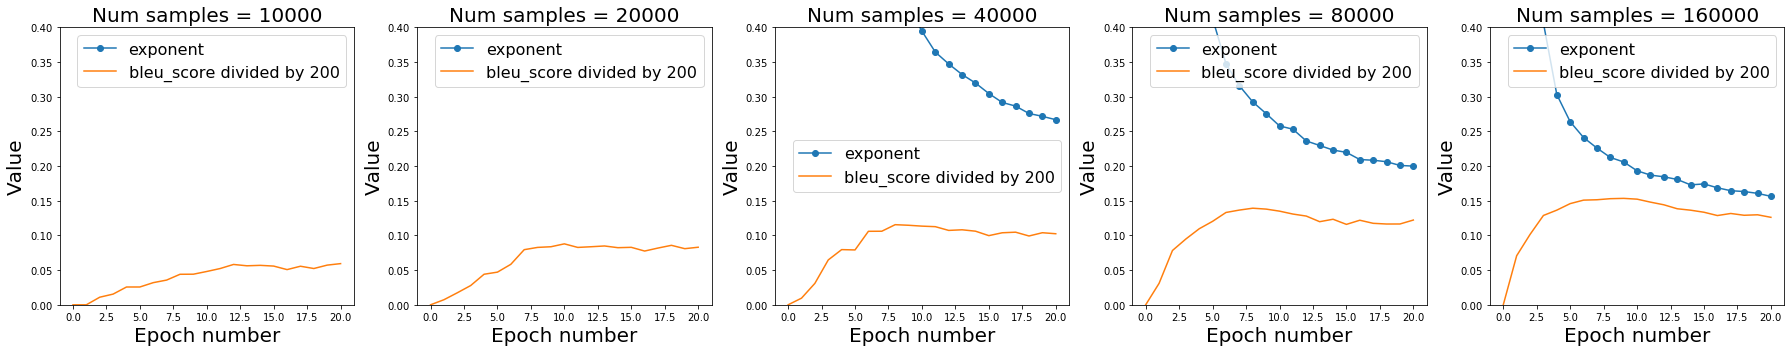

In [8]:
# You can choose between WMT or IWSLT (default)
args = arguments()
args.training_type = 'no_dropout'
#args.training_type = 'normal'
args.experiment_type = 'sample'
args.dataset='IWSLT'
#args.dataset='WMT'
args.IWSLT_width = 512
args.only20 = True

ckpt_folders, epoch_collections, _, _ = get_experiment_folders_and_epochs(args)
#plot_once(args, ckpt_folders, epoch_collections, additional_keys=['rand_num_spikes'])
#plot_once(args, ckpt_folders, epoch_collections, additional_keys=['rand_distance'], divide=100, ymax=0.32)
#plot_once(args, ckpt_folders, epoch_collections, additional_keys=['num_spikes'])
#plot_once(args, ckpt_folders, epoch_collections, additional_keys=['entropy'], divide=10, ymax=2)
#plot_once(args, ckpt_folders, epoch_collections, additional_keys=['log_spectral_norm'], ymax=3)
#plot_once(args, ckpt_folders, epoch_collections, additional_keys=['alpha_weighted'])
#plot_once(args, ckpt_folders, epoch_collections, additional_keys=['stable_rank'], divide=1, ymax=50,)
#plot_once(args, ckpt_folders, epoch_collections, additional_keys=['log_norm'])
#plot_once(args, ckpt_folders, epoch_collections, additional_keys=['D'], divide=100)
#plot_once(args, ckpt_folders, epoch_collections, additional_keys=['log_alpha_norm'], divide=1)
#plot_once(args, ckpt_folders, epoch_collections)
plot_once(args, ckpt_folders, epoch_collections, additional_keys=['exponent'], divide=200, ymax=0.4, )
#          save=f"results/{args.dataset}_{args.training_type}_exponent.pdf")
#plot_once(args, ckpt_folders, epoch_collections, min_alpha=True)
# This is for exponential distribution
#plot_once(args, ckpt_folders, epoch_collections, additional_keys=['exponent'], divide=100, ymax=0.8, )
# This is for lognormal distribution
#plot_once(args, ckpt_folders, epoch_collections, additional_keys=['sigma_var'], divide=10, ymax=30)

# Use the Ds to weight the alphas
#plot_once(args, ckpt_folders, epoch_collections, get_alpha_from_Ds=True, special_legend='alpha_weighted')
#plot_once(args, ckpt_folders, epoch_collections, get_alpha_from_Ds=True, special_legend='alpha')

# Plot alpha curves
#plot_once(args, ckpt_folders, epoch_collections, get_alpha_from_Ds=True, 
#              plot_layer_curves=True, layer_ids=all_layers, from_Ds=True)

#plt.rcParams['figure.dpi'] = 50
# results for per-layer alpha
# One can choose between using the temperature-averaged alphas or not
#plot_once(args, ckpt_folders, epoch_collections, draw_per_epoch=True, from_Ds=False)
#plot_once(args, ckpt_folders, epoch_collections, draw_per_epoch=True, from_Ds=True)
# results for per-layer spikes
#plot_once(args, ckpt_folders, epoch_collections, draw_per_epoch=True, per_layer='spikes')
# results for per-layer exponents
#plot_once(args, ckpt_folders, epoch_collections, draw_per_epoch=True, per_layer='exponent')

#plt.rcParams['figure.dpi'] = 300
#plot_once(args, ckpt_folders, epoch_collections, draw_per_epoch=True, ESD=True, layer_id = 329, ESD_type=1)

#plt.rcParams['figure.dpi'] = 300
#for layer_id in [322]:
#for layer_id in all_layers:
#    if layer_id > 0:
#        plot_once(args, ckpt_folders, epoch_collections, draw_per_epoch=True, 
#                    ESD=True, layer_id = layer_id, ESD_type=1, save=f'results/SP_LARGE_ESD{layer_id}.png')
#        plot_once(args, ckpt_folders, epoch_collections, draw_per_epoch=True, 
#                  ESD=True, layer_id = layer_id, ESD_type=1, save=None)

# ESD results for all the layers together
#plt.rcParams['figure.dpi'] = 150
#ckpt_folder, epochs = ckpt_folders[3], epoch_collections[3]
#print(ckpt_folder, epochs)
#plot_all_layers(ckpt_folder, epochs, layer_ids = all_layers[60:100], ESD_type = 1, 
#                save='results/ALL_LATER_LAYERS_WMT_SP_1280000_ALPHA_LOG_LOG_EXPCUTOFF_Normal.png')
#plot_all_layers(ckpt_folder, epochs, layer_ids = all_layers[60:100], ESD_type = 4, 
#                save='results/ALL_LATER_LAYERS_WMT_SP_1280000_KS.png')
#plot_all_layers(ckpt_folder, epochs, layer_ids = all_layers[60:100], ESD_type = 4, 
#                save='results/ALL_LATER_LAYERS_WMT_SP_1280000_ALPHA_XMIN_CURVE.png', from_Ds=True, plot_difference=False)


# Alpha values for models with different widths

Missing result ../checkpoint/NMT_epochs/IWSLT/w128/no_dropout/metrics_lognormal/epoch_0/results.pkl or ../checkpoint/NMT_epochs/IWSLT/w128/no_dropout/log_0.txt
Missing results for val=128. Continue to next value
Missing result ../checkpoint/NMT_epochs/IWSLT/w256/no_dropout/metrics_lognormal/epoch_0/results.pkl or ../checkpoint/NMT_epochs/IWSLT/w256/no_dropout/log_0.txt
Missing results for val=256. Continue to next value
Missing result ../checkpoint/NMT_epochs/IWSLT/w512/no_dropout/metrics_lognormal/epoch_0/results.pkl or ../checkpoint/NMT_epochs/IWSLT/w512/no_dropout/log_0.txt
Missing results for val=512. Continue to next value
Missing result ../checkpoint/NMT_epochs/IWSLT/w768/no_dropout/metrics_lognormal/epoch_0/results.pkl or ../checkpoint/NMT_epochs/IWSLT/w768/no_dropout/log_0.txt
Missing results for val=768. Continue to next value
Missing result ../checkpoint/NMT_epochs/IWSLT/w1024/no_dropout/metrics_lognormal/epoch_0/results.pkl or ../checkpoint/NMT_epochs/IWSLT/w1024/no_dropout/

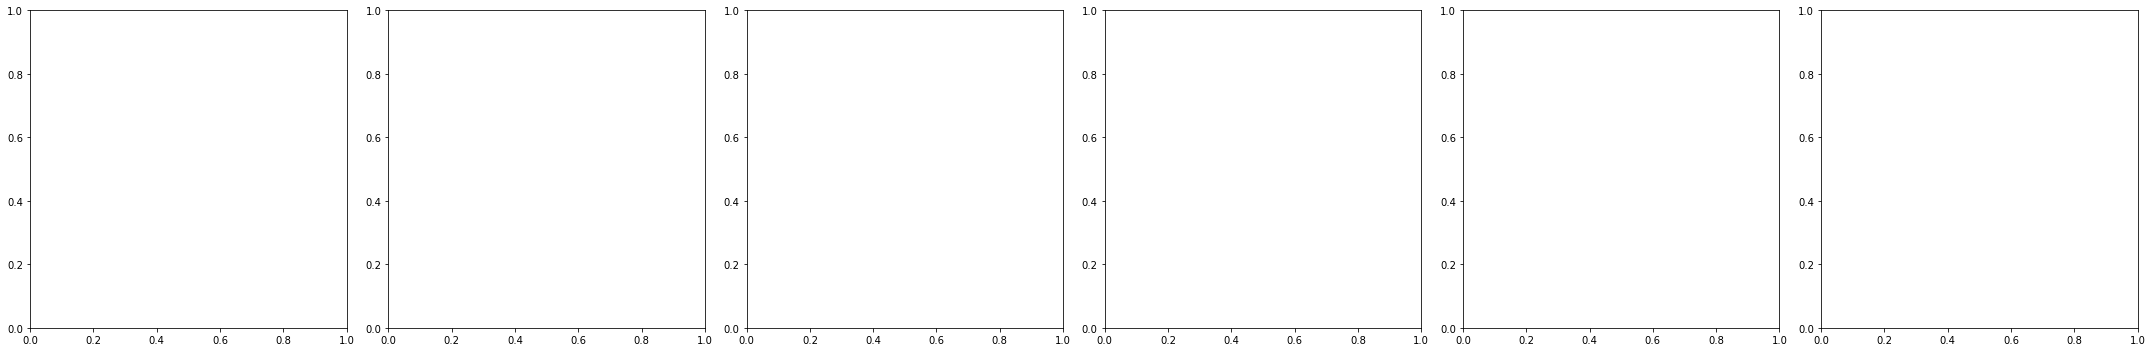

In [59]:
# You can choose between const_lr and normal. You can also set args.second_exp to be true for the const_lr experiment
args = arguments()
args.training_type = 'no_dropout'
#args.training_type = 'normal'
#args.second_exp = True
ckpt_folders, epoch_collections, _, _ = get_experiment_folders_and_epochs(args)
#plot_once(args, ckpt_folders, epoch_collections, draw_only_spikes=True)
plot_once(args, ckpt_folders, epoch_collections)

#plt.rcParams['figure.dpi'] = 50
# results for per-layer alpha
#plot_once(args, ckpt_folders, epoch_collections, draw_per_epoch=True)
# results for per-layer spikes
#plot_once(args, ckpt_folders, epoch_collections, draw_per_epoch=True, per_layer='spikes')

#plt.rcParams['figure.dpi'] = 300
#for layer_id in [264]:
#for layer_id in all_layers[80:]:
#    plot_once(args, ckpt_folders, epoch_collections, draw_per_epoch=True, 
#              ESD=True, layer_id = layer_id, ESD_type=1, save=f'results/WIDTH_INVLR_ESD{layer_id}.png')
#    #plot_once(args, ckpt_folders, epoch_collections, draw_per_epoch=True, 
#    #          ESD=True, layer_id = layer_id, ESD_type=1, save=None)

# ESD results for all the layers together
#plt.rcParams['figure.dpi'] = 150
#ckpt_folder, epochs = ckpt_folders[2], epoch_collections[2]
#print(ckpt_folder, epochs)
#plot_all_layers(ckpt_folder, epochs, layer_ids = all_layers[60:80], ESD_type = 6, 
#                save='results/ALL_LAYERS_WIDTH_512_CONST_LR_MPFIT2_60_80.png')

# Alpha values for models trained with different learning rates

In [ ]:
# You can choose between WMT or IWSLT (default)
args = arguments()
args.experiment_type = 'lr'
ckpt_folders, epoch_collections, _, _ = get_experiment_folders_and_epochs(args)
plot_once(args, ckpt_folders, epoch_collections)
# Look at the number of spikes
#plot_once(args, ckpt_folders, epoch_collections, draw_only_spikes=True)

#plt.rcParams['figure.dpi'] = 50
# results for per-layer alpha
#plot_once(args, ckpt_folders, epoch_collections, draw_per_epoch=True)
# results for per-layer spikes
#plot_once(args, ckpt_folders, epoch_collections, draw_per_epoch=True, per_layer='spikes')


#plt.rcParams['figure.dpi'] = 300
#plot_once(args, ckpt_folders, epoch_collections, draw_per_epoch=True, ESD=True, layer_id = 329, ESD_type=6)

#for layer_id in [264]:
#for layer_id in all_layers:
#    if layer_id > 113:
#        plot_once(args, ckpt_folders, epoch_collections, draw_per_epoch=True, 
#                  ESD=True, layer_id = layer_id, ESD_type=1, save=f'results/LR_ESD{layer_id}.png')
#    #plot_once(args, ckpt_folders, epoch_collections, draw_per_epoch=True, 
#    #          ESD=True, layer_id = layer_id, ESD_type=4, save=None)

# ESD results for all the layers together
#plt.rcParams['figure.dpi'] = 150
#ckpt_folder, epochs = ckpt_folders[4], epoch_collections[4]
#print(ckpt_folder, epochs)
# switch between square layers and ordinary layers below
#plot_all_layers(ckpt_folder, epochs, layer_ids = all_layers[80:100], ESD_type = 8, 
#                save='results/ALL_LAYERS_LR_4_RANDOMIZE2_80_100.png')
#plot_all_layers(ckpt_folder, epochs, layer_ids = all_layers_square[:20], ESD_type = 5, 
#                save='results/ALL_LAYERS_LR_MIDDLE_MP_FIT1_0_20.png')

# Computing the rank correlation 

FileNotFoundError: [Errno 2] No such file or directory: '../checkpoint/NMT_epochs/WMT_sample_160000_new/w512/normal/robust_measures.pkl'

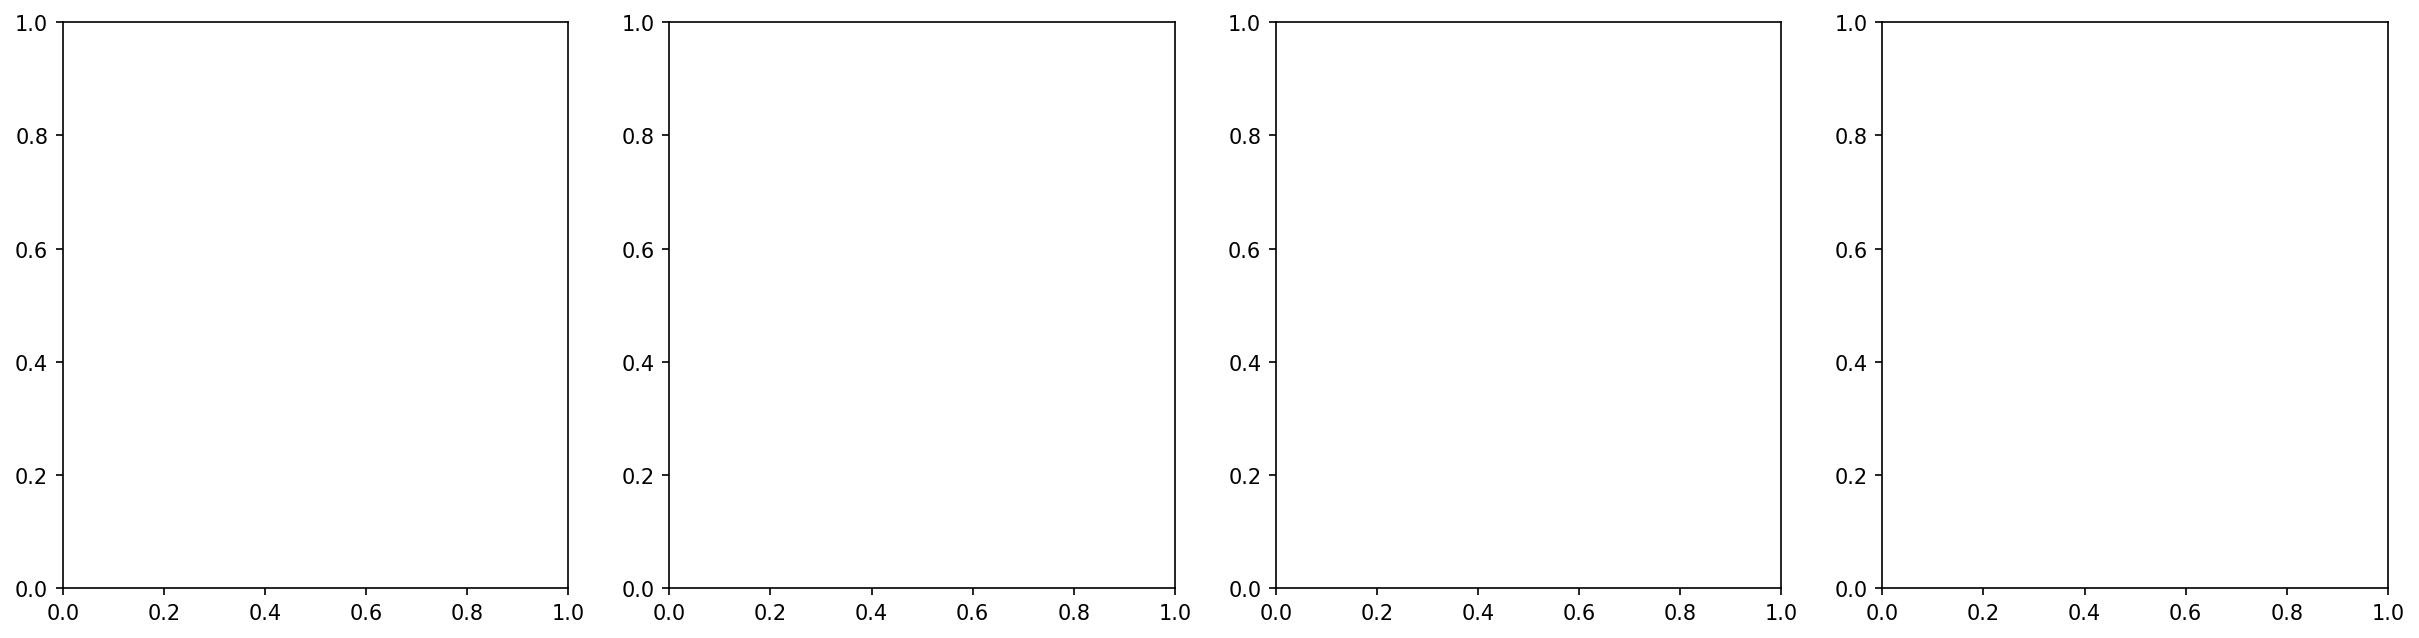

In [8]:
from analyze_plots_utils import change_dict_form, compute_correlation_single, compute_rank_correlation 
from analyze_plots_utils import create_plot_result, aggregate_rank_correlations, average_rank_correlations, plot_rank_correlations 

keys = ['log_norm', 'alpha', 'alpha_weighted', 'log_alpha_norm', 'log_spectral_norm', 'stable_rank']
single_features = ['rand_distance', 'entropy', 'bulk_mean_vec_entropy', 'bulk_var_vec_entropy', 'tail_mean_vec_entropy', 'tail_var_vec_entropy', 'exponent']
exclude_metrics = ['FRO_OVER_SPEC', 'PARAMS', 'alpha']

rank_correlations_min = {}
rank_correlations_ave = {}
    
for training_type in ['normal', 'no_dropout']:
    for dataset in ['WMT', 'IWSLT']:
        
        args = arguments()
        args.training_type = training_type
        args.dataset = dataset
        args.experiment_type = 'sample'
        args.IWSLT_width = 512
        args.only20 = True
        #args.correlation_type = 'pearsonr'
        args.correlation_type = 'spearmanr'

        if args.training_type=='no_dropout':
            training_type_suffix = 'without dropout'
        else:
            training_type_suffix = 'with dropout'

        plt.rcParams['figure.dpi'] = 150
        ckpt_folders, epoch_collections, _, _ = get_experiment_folders_and_epochs(args)
        figs, axs = plt.subplots(1,len(ckpt_folders), figsize=(5*len(ckpt_folders),5))

        for ckpt_folder, epochs, ax in zip(ckpt_folders, epoch_collections, axs):

            num_samples = re.findall(r'\d+', ckpt_folder)[0]    
            mypath = os.path.join(ckpt_folder, 'robust_measures.pkl')
            different_metrics = change_dict_form(mypath)

            plot_result = create_plot_result(keys, single_features, exclude_metrics)
            loss_result = os.path.join(ckpt_folder, 'log_0.txt')
            get_bleu_score(plot_result, loss_result, divide=1)
            
            for epoch in epochs:
                #ww_result = os.path.join(ckpt_folder, 'metrics_new', f'epoch_{epoch}', 'results_Charles_rand_distance.pkl')
                #ww_result = os.path.join(ckpt_folder, 'metrics_new', f'epoch_{epoch}', 'results_Charles_fix_finger.pkl')
                #ww_result = os.path.join(ckpt_folder, 'metrics', f'epoch_{epoch}', 'results_continuous30.pkl')
                #ww_result = os.path.join(ckpt_folder, 'metrics', f'epoch_{epoch}', 'results_continuous30_heuMax_1.pkl')
                #ww_result = os.path.join(ckpt_folder, 'metrics_new', f'epoch_{epoch}', 'results.pkl')
                #ww_result = os.path.join(ckpt_folder, 'metrics_expcutoff', f'epoch_{epoch}', 'results.pkl')

                ww_result1 = os.path.join(ckpt_folder, 'metrics', f'epoch_{epoch}', 'results.pkl')
                get_ww_result(plot_result, ww_result1, keys, get_alpha_from_Ds=False)

                ww_result2 = os.path.join(ckpt_folder, 'metrics_expcutoff', f'epoch_{epoch}', 'results.pkl')
                for key in single_features:
                    plot_result[key].append( np.mean(get_ww_layer_feature(ww_result2, key=key)))

                # Add the keys for exponential distribution
                ww_result3 = os.path.join(ckpt_folder, 'metrics_exponential', f'epoch_{epoch}', 'results.pkl')
                plot_result['exp_dist_exponent'].append( np.mean(get_ww_layer_feature(ww_result3, key='exponent')))

                # Add the keys for lognormal distribution
                ww_result4 = os.path.join(ckpt_folder, 'metrics_lognormal', f'epoch_{epoch}', 'results.pkl')
                plot_result['lognormal_sigma'].append( np.mean(get_ww_layer_feature(ww_result4, key='sigma_var')))

            rank_correlations = compute_rank_correlation(plot_result, different_metrics, exclude_metrics = exclude_metrics,
                        correlation_type = args.correlation_type, single_features=['exp_dist_exponent','lognormal_sigma']+single_features)
            
            aggregate_rank_correlations(rank_correlations, rank_correlations_min, rank_correlations_ave)
                        
            plot_rank_correlations(rank_correlations, ax)
            
            ax.set_title(f"{args.dataset}, num samples={num_samples},\n training {training_type_suffix}")
            if args.correlation_type == 'pearsonr':
                ax.set_xlabel('Pearson correlation')
            elif args.correlation_type == 'spearmanr':
                ax.set_xlabel("Spearman's rank correlation")
            #ax.set_xticklabels(plot_keys, rotation=90)
            
        plt.tight_layout()
        plt.savefig(f"results/Rank_correlation_{args.dataset}_{num_samples}_samples_{args.training_type}.pdf")
        
average_rank_correlations(rank_correlations_ave)

print(rank_correlations_ave)

# Plot average rank correlations
figs, ax = plt.subplots(1,1,figsize=(5,5))
plot_rank_correlations(rank_correlations_ave, ax)

ax.set_title(f"Average rank correlations")
if args.correlation_type == 'pearsonr':
    ax.set_xlabel('Pearson correlation')
elif args.correlation_type == 'spearmanr':
    ax.set_xlabel("Spearman's rank correlation")
plt.tight_layout()
plt.savefig(f"results/Average_rank_correlations.pdf")

# Plot min rank correlations
figs, ax = plt.subplots(1,1,figsize=(5,5))
plot_rank_correlations(rank_correlations_min, ax)

ax.set_title(f"Worst-case rank correlations")
if args.correlation_type == 'pearsonr':
    ax.set_xlabel('Pearson correlation')
elif args.correlation_type == 'spearmanr':
    ax.set_xlabel("Spearman's rank correlation")
plt.tight_layout()
plt.savefig(f"results/Worst_case_rank_correlations.pdf")


# alpha values for models trained on Computer vision

In [ ]:
mypath = '/scratch/yyaoqing/model_zoo/epoch_200/normal/ResNet50/metrics/epoch_10/'
all_layers = get_all_layers(mypath)

In [ ]:
args = arguments()
args.experiment_type = 'CV'
#ckpt_folder = '/scratch/yyaoqing/model_zoo/epoch_200/normal/ResNet18/'
ckpt_folder = '/scratch/yyaoqing/model_zoo/epoch_200/normal/ResNet50/'
epochs = [x for x in range(10, 210, 10)]

ckpt_folders, epoch_collections = [ckpt_folder, ckpt_folder], [epochs, epochs]
#plt.rcParams['figure.dpi'] = 50
#plot_once(args, ckpt_folders, epoch_collections, draw_per_epoch=True)

# ESD results for all the layers together
plt.rcParams['figure.dpi'] = 150
ckpt_folder, epochs = ckpt_folders[0], epoch_collections[0]
print(ckpt_folder, epochs)
plot_all_layers(ckpt_folder, epochs=epochs, layer_ids = all_layers[20:40], ESD_type = 1, 
                save='results/ALL_LAYERS_RESNET50.png')

## Plotting single result

In [ ]:
def plot_train_val(ckpt_folder):
    
    loss_result = os.path.join(ckpt_folder, 'log_0.txt')

    plot_result = {}
    get_train_loss(plot_result, loss_result)
    get_val_loss(plot_result, loss_result)
    get_bleu_score(plot_result, loss_result)

    num_epochs = len(plot_result['validation_loss'])

    plt.figure(figsize=(5,5))
    plt.plot(np.arange(1,num_epochs+1), plot_result['validation_loss'], label = 'validation loss')
    plt.plot(np.arange(1,num_epochs), plot_result['bleu_score'], label = 'BLEU score')
    plt.xlabel("Training epochs")
    plt.ylabel("Value")
    plt.plot(np.linspace(0, num_epochs, len(plot_result['training_loss'])), plot_result['training_loss'], label = 'training loss')
    plt.plot(np.linspace(0,200,1000), [min(plot_result['validation_loss'])]*len(np.linspace(0,200,1000)))
    #ax.plot(, plot_result[key], label=key) 
    plt.ylim([0,15])
    plt.legend()

### what happens if we apply the sharpness transform?
### after using sharpness transform

In [ ]:
ckpt_folder = './debug_results_Sharpness_w128/'
plot_train_val(ckpt_folder)

### not using the sharpness transform

In [ ]:
ckpt_folder = './debug_results_noSharpness_w128/'
plot_train_val(ckpt_folder)

### using sharpness transform on WMT data

In [ ]:
ckpt_folder = './debug_results_WMT_Sharpness_w512/'
plot_train_val(ckpt_folder)

### using sharpness transform on WMT data, per batch

In [ ]:
ckpt_folder = './debug_results_WMT_Sharpness_perbatch_w512/'
plot_train_val(ckpt_folder)

## Check all the layer results for the BERT fine-tuning

In [ ]:
mypath = '../checkpoint/BERT_finetune/clean/metrics/epoch_0/'
all_layers = get_all_layers(mypath)
all_layers_square = get_all_layers_square(mypath)

In [ ]:
# ESD results for all the layers together
plt.rcParams['figure.dpi'] = 150
ckpt_folder = '../checkpoint/BERT_finetune/clean/'  #'metrics/epoch_1'
epochs = [0,1,2,3,4,5,6,7,8,9]
print(ckpt_folder, epochs)
plot_all_layers(ckpt_folder, epochs, layer_ids = all_layers[60:80], ESD_type = 1, 
                save='results/ALL_LAYERS_BERT_FINETUNE_ESD_60_80.png')

## SVDSmoothing on the models trained from scratch

In [ ]:
import os
import pickle
import matplotlib.pyplot

In [ ]:
def analyze_SVDSmoothing_file(file_name):
    
    print(file_name)
    with open(file_name, 'r') as f:
        lines = f.readlines()
        for line in lines:
            x = line.split(" ")
            if "Validation" in x and "loss" in x and 'at' in x:
                Smooth_val = float(x[-1])
            if "BLEU" in x and "score" in x and 'is' in x:
                Smooth_BLEU = float(x[-1])
    
    return Smooth_val, Smooth_BLEU

In [ ]:
def find_int(x):
    return int(re.search(r'\d+', x).group())

In [ ]:
def find_epochs(ckpt_folder):
    
    epoch_folder = os.path.join(ckpt_folder, 'metrics/')
    lst = os.listdir(epoch_folder)
    epochs = [find_int(x) for x in lst]
    epochs.sort()
    return epochs

In [ ]:
def plot_SVD_smoothing(ckpt_folder, ax, title):
    
    loss_result = os.path.join(ckpt_folder, 'log_0.txt')

    plot_result = {}
    get_train_loss(plot_result, loss_result)
    get_val_loss(plot_result, loss_result)
    get_bleu_score(plot_result, loss_result)
    
    # Find epochs from folder
    epochs = find_epochs(ckpt_folder)
    
    Smooth_vals = []
    Smooth_BLEUs = []
    for epoch in epochs:
        SVDSmoothing_file_name = os.path.join(ckpt_folder, 'metrics', f'epoch_{epoch}', 'SVDsmoothing_RMT.log')
        Smooth_val, Smooth_BLEU = analyze_SVDSmoothing_file(SVDSmoothing_file_name)
        Smooth_vals.append(Smooth_val)
        Smooth_BLEUs.append(Smooth_BLEU)

    num_epochs = len(plot_result['validation_loss'])

    ax.plot(np.arange(1,num_epochs+1), plot_result['validation_loss'], label = 'validation loss', color='r')
    ax.plot([x+1 for x in epochs], Smooth_vals, label = 'SVDSmoothing loss')
    #plt.plot([x+1 for x in epochs], Smooth_BLEUs, label = 'SVDSmoothing BLEU')
    #plt.plot(np.arange(1,num_epochs), plot_result['bleu_score'], label = 'BLEU score')
    ax.set_xlabel("Training epochs")
    ax.set_ylabel("Loss")
    ax.plot(np.linspace(0, num_epochs-1, len(plot_result['training_loss'])), plot_result['training_loss'], label = 'training loss', color='g')
    #ax.plot(, plot_result[key], label=key) 
    ax.set_ylim([0,7])
    ax.set_title(title)
    ax.legend()

In [ ]:
fig, axs = plt.subplots(1,5, figsize=(25,5))

for i, num_samples in enumerate([10000, 20000, 40000, 80000, 160000]):
#for i, num_samples in enumerate([160000, 10000, 20000, 40000]):
    
    ckpt_folder = f'../checkpoint/NMT_epochs/IWSLT_sample_{num_samples}/w512/normal/'
    plot_SVD_smoothing(ckpt_folder, axs[i], title=f'IWSLT {num_samples} samples')

# Plotting the localization ratios

In [ ]:
name = 'eigs'
#name = 'loc_ratio'

plt.rcParams['figure.dpi'] = 300
mypath = '../checkpoint/NMT_epochs/IWSLT_sample_160000/w512/normal/metrics/epoch_5'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and name in f]
num_cols = 5
num_rows = len(onlyfiles)//num_cols +1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*2.5, num_rows*2.5))
for fig_id, f in enumerate(onlyfiles):
    file_name = os.path.join(mypath, f)
    row = fig_id//num_cols
    col = fig_id%num_cols
    
    img = mpimg.imread(file_name)
    axs[row, col].imshow(img)
    axs[row, col].axis('off')
    
plt.tight_layout()
plt.savefig(f'{name}.png')

# SVDSmoothing using random matrix theory

In [ ]:
val_loss = [0.22604, 0.22785, 0.28892, 0.31808, 0.32514, 0.34086, 0.33148, 0.38222, 0.37631, 0.36915]

In [ ]:
plt.plot(val_loss)